In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import model_selection
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
%matplotlib inline
import seaborn as sns
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.externals import joblib

C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('armMotionDataset.csv', lineterminator='\n')
data.rename(columns={"motionTime\r": "motionTime"},inplace=True)
data = data[data.id != 999] # remove the extra sample..
scores = pd.read_csv('armSortedScores.csv', lineterminator='\n')
scores.rename(columns={"gif_id\r": "gif_id"},inplace=True)
scores_concat = scores.copy(deep = True)

In [3]:
FEATURES = ["WtCohesion", "WtAlignment", "WtSeparation", "WtSeek", "wtExpBlend", "Speed", "Neighbourhood", "WanderFreq", "wanderRadius", "kickTime"] 
FEATURESALL = ["WtCohesion", "WtAlignment", "WtSeparation", "WtSeek", "wtExpBlend", "Speed", "Neighbourhood", "WanderFreq", "wanderRadius", "kickTime","VelDirType","dampExplore"]

In [4]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu", "more-afraid_mu", "more-surprised_mu", "more-disgusted_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma", "more-afraid_sigma","more-surprised_sigma", "more-disgusted_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
WTS_LABEL = ["happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt","more-surprised_wt", "more-disgusted_wt"]

In [5]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [6]:
mapperLR = DataFrameMapper([
...     (['WtCohesion', 'WtAlignment','WtSeparation', 'WtSeek', 'wtExpBlend', 'Speed', 'Neighbourhood','WanderFreq', 'wanderRadius', 'kickTime'], preprocessing.StandardScaler()),
...     (['VelDirType'], preprocessing.OneHotEncoder()),    
...     (['dampExplore'], preprocessing.OneHotEncoder())], input_df = True)

In [7]:
WTS= {'happier_wt':(1.0-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.0-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.0-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values,
      'more-afraid_wt':(1.0-(scores[EMOCONFIDENCE_INV[3]]/min_confidence)).values,
     'more-surprised_wt':(1.0-(scores[EMOCONFIDENCE_INV[4]]/min_confidence)).values,
     'more-disgusted_wt':(1.0-(scores[EMOCONFIDENCE_INV[5]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,scores.index)

In [8]:
model_dir_name = "/Users/rutad/Documents/bitbucket/pythonTF/LRBaselineArm/"

[  1.53739354e+01  -1.36714381e-01   1.40702161e+00  -1.60220324e+00
   4.52780726e-01   7.80960709e-01   2.77674049e+00  -3.98133961e-02
  -2.97569297e-01   1.87703934e-01   7.10627530e-03   2.76037902e+00
   3.22420123e+00   1.62978974e+00   2.12390441e+00   3.01661217e+00
   2.61904880e+00   7.82817738e+00   7.54575797e+00]
Populating the interactive namespace from numpy and matplotlib


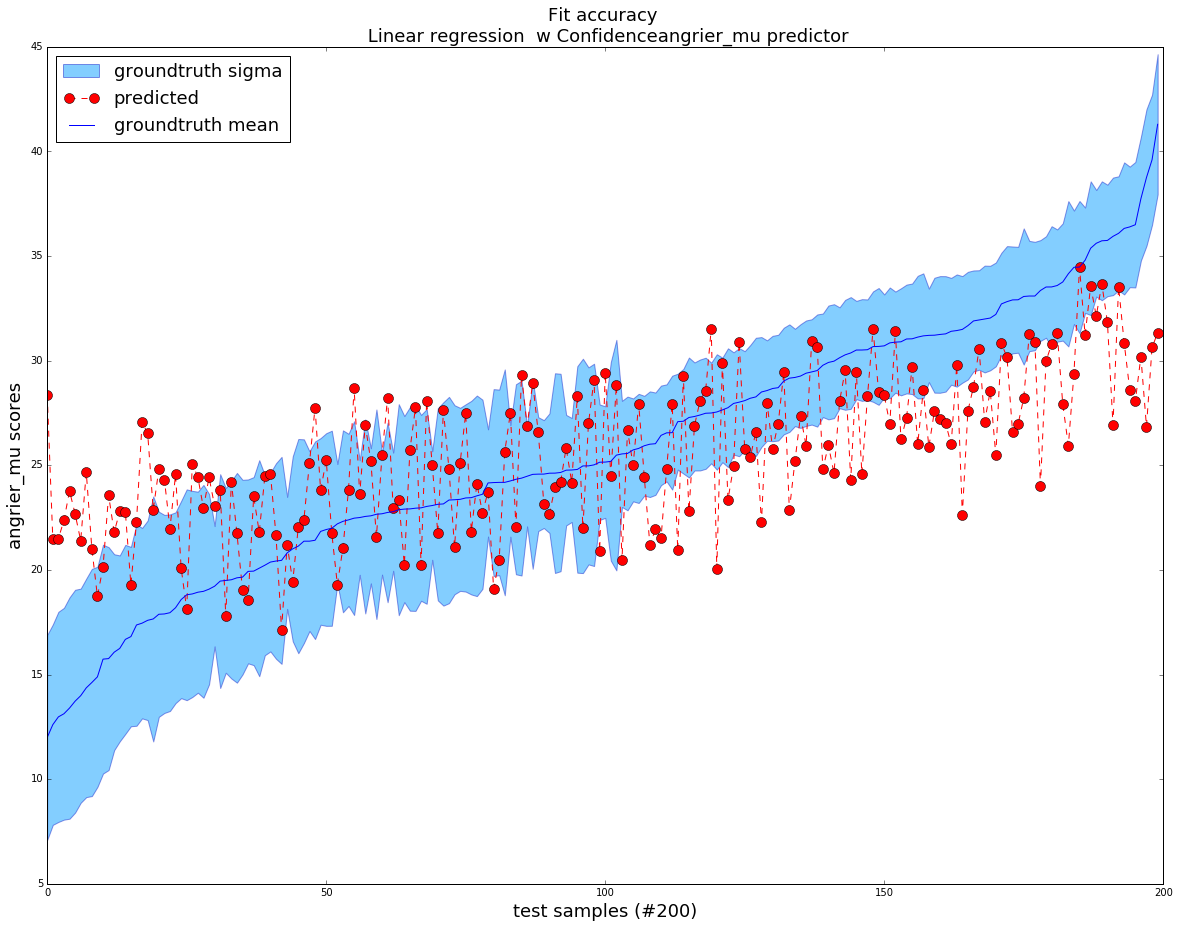

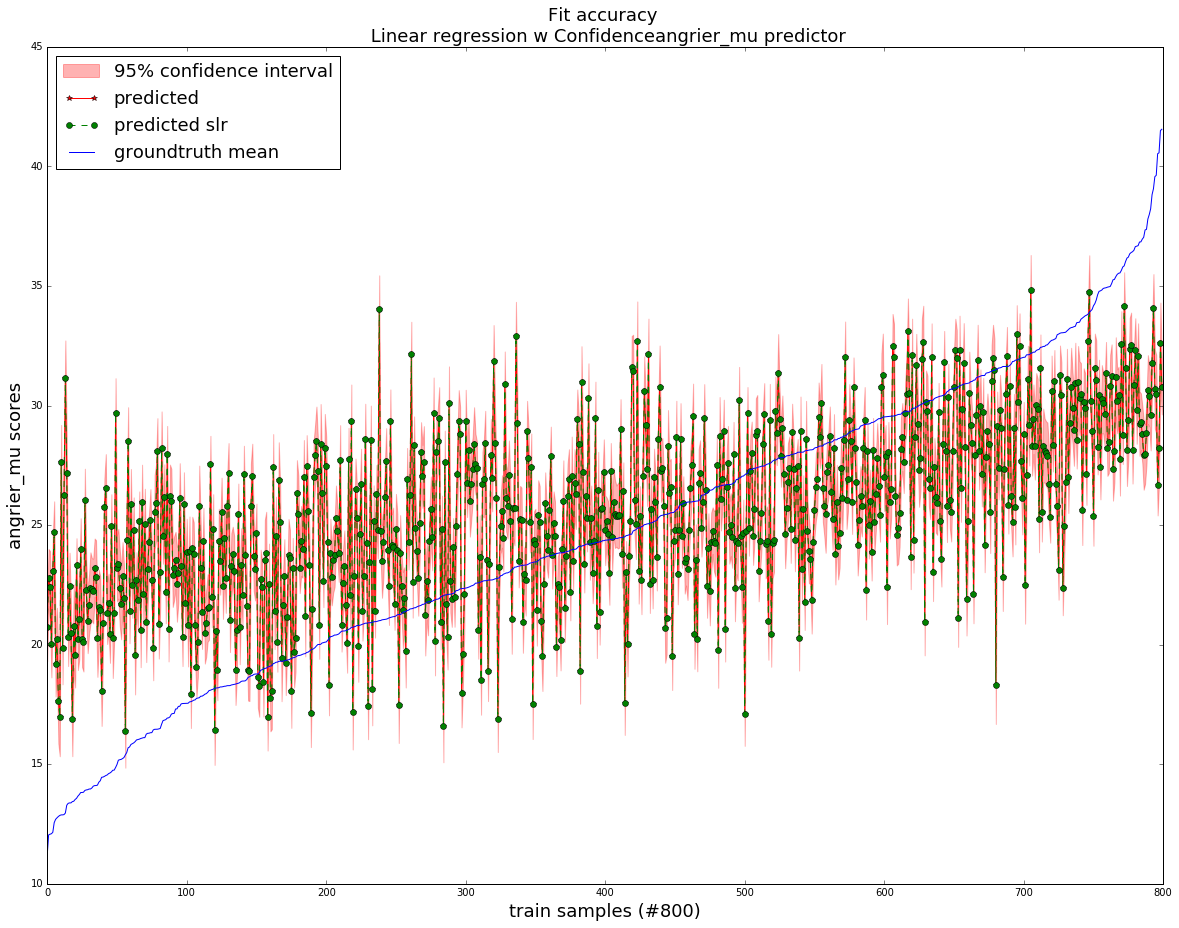

In [9]:
transformedDataLR = mapperLR.fit_transform(data.copy())

scores_WTS = pd.concat([scores, WTS_df], axis = 1)

X_trainLR, X_testLR, y_trainLR, y_testLR = model_selection.train_test_split(transformedDataLR, scores_WTS, test_size=0.2, random_state=42)
X_trainSLR = statsmodels.tools.add_constant(X_trainLR,has_constant='add')
X_testSLR = statsmodels.tools.add_constant(X_testLR,has_constant='add')

# getting prediction for complete dataset using our LR model for showing gallery motions
allDataSLR = statsmodels.tools.add_constant(transformedDataLR)

for i in range (2,3):
    LABEL_ID = i;
    LABEL = EMOSCORES[LABEL_ID]
    WT_COL = WTS_LABEL[LABEL_ID]
    predicted_name ="predicted_"+LABEL
    predicted_name_train ="predicted_"+LABEL+"_train"
    model_save_name = model_dir_name + "SLRTrainedArm_"+LABEL+".pkl"
    
    lr.fit(X_trainLR, y_trainLR[EMOSCORES[LABEL_ID]],sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    slr = sm.WLS(y_trainLR[EMOSCORES[LABEL_ID]].values,X_trainSLR, weights = y_trainLR[WTS_LABEL[LABEL_ID]].values)
    fslr = slr.fit()
    print(fslr.params)
    #joblib.dump(fslr,model_save_name)

    ytest_pred_lr=lr.predict(X_testLR)
    ytrain_pred_lr=lr.predict(X_trainLR)
    ytest_pred_slr = fslr.predict(X_testSLR)
    ytrain_pred_slr=fslr.predict(X_trainSLR)
    allData_pred_slr = fslr.predict(allDataSLR)
    
    testmse = metrics.mean_squared_error(y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_lr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]])
    testr2 = metrics.r2_score( y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_lr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]])
    trainmse = metrics.mean_squared_error( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_lr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    trainr2 = metrics.r2_score( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_lr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    
    testmse_slr = metrics.mean_squared_error(y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_slr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]])
    testr2_slr = metrics.r2_score( y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_slr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]])
    trainmse_slr = metrics.mean_squared_error( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_slr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    trainr2_slr = metrics.r2_score( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_slr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])
    
    prstd_slr, iv_l_slr, iv_u_slr = wls_prediction_std(fslr, weights = [1])
    train_pred = fslr.get_prediction(X_trainSLR).summary_frame(alpha=0.05)
    train_pred.index = y_trainLR[LABEL].index
    test_pred = fslr.get_prediction(X_testSLR).summary_frame(alpha=0.05)
    test_pred.index = y_testLR[LABEL].index
    
    y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_testLR[LABEL].index) 
    y_hat_slr = pd.DataFrame(ytest_pred_slr, columns=[predicted_name], index=y_testLR[LABEL].index)     
    y_all_testlr = pd.concat([y_hat_lr, y_testLR[LABEL], y_testLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
    y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[LABEL_ID],ascending=[True])
    y_all_testslr = pd.concat([y_hat_slr, test_pred["mean_ci_lower"], test_pred["mean_ci_upper"],
                               test_pred["obs_ci_lower"], test_pred["obs_ci_upper"],
                               y_testLR[LABEL], y_testLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
    y_all_testslr_sorted = y_all_testslr.sort_values(EMOSCORES[LABEL_ID],ascending=[True])
    
    ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name_train], index=y_trainLR[LABEL].index)
    ytrain_hat_slr = pd.DataFrame(ytrain_pred_slr, columns=[predicted_name_train], index=y_trainLR[LABEL].index) 
    ivl_hat_slr = pd.DataFrame(iv_l_slr, columns=["lower"], index=y_trainLR[LABEL].index) 
    ivu_hat_slr = pd.DataFrame(iv_u_slr, columns=["upper"], index=y_trainLR[LABEL].index) 
    
    y_all_trainlr = pd.concat([ytrain_hat_lr, y_trainLR[LABEL], y_trainLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
    y_all_trainlr_sorted = y_all_trainlr.sort_values(LABEL,ascending=[True])
    y_all_trainslr = pd.concat([ytrain_hat_slr, ivl_hat_slr, ivu_hat_slr, 
                                train_pred["mean_ci_lower"], train_pred["mean_ci_upper"],
                                train_pred["obs_ci_lower"], train_pred["obs_ci_upper"],
                                y_trainLR[LABEL], y_trainLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
    y_all_trainslr_sorted = y_all_trainslr.sort_values(LABEL,ascending=[True])
    
    %pylab inline
    pylab.rcParams['figure.figsize'] = (20, 15)
    ax =plt.figure()
    x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
    #plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-*',label="predicted")
    #plt.errorbar(x,y_all_testslr_sorted[predicted_name].values,fmt='g--o',label="predicted slr")
    plt.errorbar(x,y_all_testslr_sorted[predicted_name].values,fmt='r--o',markersize='10',label="predicted")
    plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
        alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF', label='groundtruth sigma')
    #plt.fill_between(x, y_all_testslr_sorted["mean_ci_lower"],y_all_testslr_sorted["mean_ci_upper"],alpha=0.3, edgecolor='r', facecolor='#089FFF', label='95% confidence interval')
    #plt.fill_between(x, y_all_testslr_sorted["obs_ci_lower"],y_all_testslr_sorted["obs_ci_upper"],alpha=0.3, edgecolor='g', facecolor='g', label='prediction interval')
    plt.errorbar(x,y_all_testlr_sorted[LABEL].values,fmt='b',label="groundtruth mean")
    #plt.title(model_dir_name,fontsize=18)
    plt.title('Fit accuracy \n Linear regression  w Confidence' + LABEL + ' predictor',fontsize=18)
    plt.xlabel('test samples (#'+str(y_testLR[LABEL].size)+')',fontsize=18)
    plt.ylabel(LABEL +' scores',fontsize=18)
    pylab.legend(loc='upper left', fontsize=18)
    plt.show()
    fig_name = model_dir_name +"/" + LABEL+ "_SLRtestpredictionArmPAPER.pdf"
    ax.savefig(fig_name)
    
    pylab.rcParams['figure.figsize'] = (20, 15)
    ax =plt.figure()
    x = np.arange(0, y_all_trainlr_sorted[predicted_name_train].size, 1)
    plt.errorbar(x,y_all_trainlr_sorted[predicted_name_train].values,fmt='r-*',label="predicted")
    plt.errorbar(x,y_all_trainslr_sorted[predicted_name_train].values,fmt='g--o',label="predicted slr")
#     plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
#         alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF', label='groundtruth sigma')
    plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth mean")
    #plt.fill_between(x, y_all_trainslr_sorted["lower"],y_all_trainslr_sorted["upper"],alpha=0.5, edgecolor='r', facecolor='#089FFF'
                    #, label='prediction interval')
    plt.fill_between(x, y_all_trainslr_sorted["mean_ci_lower"],y_all_trainslr_sorted["mean_ci_upper"],alpha=0.3, edgecolor='r', facecolor='r', label='95% confidence interval')
    #plt.fill_between(x, y_all_trainslr_sorted["obs_ci_lower"],y_all_trainslr_sorted["obs_ci_upper"],alpha=0.3, edgecolor='g', facecolor='g', label='prediction interval fn')
    #plt.title(model_dir_name,fontsize=18)
    plt.title('Fit accuracy \n Linear regression w Confidence' + LABEL + ' predictor',fontsize=18)
    plt.xlabel('train samples (#'+str(y_trainLR[LABEL].size)+')',fontsize=18)
    plt.ylabel(LABEL +' scores',fontsize=18)
    pylab.legend(loc='upper left', fontsize=18)
    plt.show()
#     fig_name = model_dir_name +"/" + LABEL+ "_SLRtrainPredictionArm.pdf"
#     ax.savefig(fig_name)

#     save_info = pd.DataFrame(columns = ['regressor name','test wtd mse', 'test wtd r2', 'train wtd mse', 'train wtd r2', 'emotion'])
#     save_info.loc[1]= ["SLR", testmse_slr, testr2_slr, trainmse_slr, trainr2_slr, LABEL]
    
#     with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\LRBaselineArm\\LRBaselineExperimentsArm.csv', 'a') as f:
#         save_info.to_csv(f, header=False, index=False)

#     predicted_name_SLR ="SLRpredicted_"+LABEL
#     allData_pred_slr_df = pd.DataFrame(allData_pred_slr, columns =[predicted_name_SLR], index = scores.index);
#     scores_concat = pd.concat([scores_concat, allData_pred_slr_df], axis =1)

In [10]:
# save_pred = scores_concat.copy();
# with open('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\LRBaseline\\sortedScoresWPredictions.csv', 'w') as f:
#     save_pred.to_csv(f, header=True, index=False)

In [11]:
export_testresults = pd.concat([y_all_testlr_sorted[LABEL], y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_testlr_sorted[predicted_name]], axis = 1)#pd.DataFrame(columns = ['groundtruth_mu','groundtruth_sigma', 'predicted_mu'])
export_testresults.to_csv('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\LRBaselineArm\\export_testResults.csv',index=False)

In [12]:
max(iv_l_slr)

27.635083141447723

In [13]:
LABEL

'angrier_mu'

In [14]:
fslr.params

array([  1.53739354e+01,  -1.36714381e-01,   1.40702161e+00,
        -1.60220324e+00,   4.52780726e-01,   7.80960709e-01,
         2.77674049e+00,  -3.98133961e-02,  -2.97569297e-01,
         1.87703934e-01,   7.10627530e-03,   2.76037902e+00,
         3.22420123e+00,   1.62978974e+00,   2.12390441e+00,
         3.01661217e+00,   2.61904880e+00,   7.82817738e+00,
         7.54575797e+00])

In [15]:
lr.coef_

array([-0.13671438,  1.40702161, -1.60220324,  0.45278073,  0.78096071,
        2.77674049, -0.0398134 , -0.2975693 ,  0.18770393,  0.00710628,
        0.19805646,  0.66187867, -0.93253282, -0.43841815,  0.45428961,
        0.05672624,  0.14120971, -0.14120971])

In [16]:
lr.intercept_

25.623225591313574

In [17]:
fslr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.365
Model:                            WLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     28.08
Date:                Thu, 29 Mar 2018   Prob (F-statistic):           2.07e-66
Time:                        14:25:42   Log-Likelihood:                -2399.5
No. Observations:                 800   AIC:                             4833.
Df Residuals:                     783   BIC:                             4913.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.3739      0.136    112.730      0.000      15.106      15.642
x1            -0.1367      0.172     -0.793      0.428      -0.475       0.202
x2             1.4070      0.174      8.098      0.000       1.066       1.748
x3            -1.6022      0.174     -9.192      0.000      -1.944      -1.260
x4             0.4528      0.175      2.590      0.010       0.110       0.796
x5             0.7810      0.214      3.642      0.000       0.360       1.202
x6             2.7767      0.179     15.499      0.000       2.425       3.128
x7            -0.0398      0.174     -0.229      0.819      -0.381       0.301
x8            -0.2976      0.207     -1.436      0.151      -0.704       0.109
x9             0.1877      0.205      0.916      0.360      -0.215       0.590
x10            0.0071      0.180      0.040      0.968      -0.346       0.360
x11            2.7604      0.363      7.603      0.000       2.048       3.473
x12            3.2242      0.386      8.347      0.000       2.466       3.982
x13            1.6298      0.419      3.888      0.000       0.807       2.453
x14            2.1239      0.377      5.639      0.000       1.385       2.863
x15            3.0166      0.378      7.970      0.000       2.274       3.760
x16            2.6190      0.406      6.453      0.000       1.822       3.416
x17            7.8282      0.281     27.883      0.000       7.277       8.379
x18            7.5458      0.194     38.802      0.000       7.164       7.928
==============================================================================
Omnibus:                        8.656   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                7.916
Skew:                           0.192   Prob(JB):                       0.0191
Kurtosis:                       2.701   Cond. No.                     1.57e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.67e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
fslr.mse_total

19.819868733204974

In [19]:
fslr.predict()

array([ 32.65886579,  23.94502201,  26.16431629,  23.85020692,
        25.95998105,  22.52618041,  29.34643325,  29.69595277,
        29.45278441,  32.04718983,  24.35100727,  22.55479952,
        24.97898603,  22.80382456,  26.11749455,  28.92470518,
        27.51832641,  31.01355806,  22.37089404,  24.62809869,
        26.20209977,  30.42849805,  27.32836976,  21.67444439,
        25.68641087,  24.76450983,  21.97132982,  24.2641537 ,
        27.68380649,  17.10786557,  17.46389729,  24.49572011,
        21.007472  ,  31.24274485,  23.94789999,  25.42783717,
        23.86271914,  28.59396936,  25.21543943,  29.64675471,
        29.97562398,  26.49508982,  25.78082082,  22.73356765,
        18.15297732,  21.40609433,  26.55748201,  26.53500401,
        26.20485408,  32.02363884,  24.20131104,  26.02570954,
        25.79820413,  20.0365715 ,  24.14894886,  27.02256848,
        24.84242809,  24.19635705,  24.32128854,  31.14165   ,
        18.05621712,  22.99291877,  30.17822405,  25.01

In [20]:
trainmse

22.874329189529217

In [21]:
fslr.get_prediction(X_testSLR).summary_frame(alpha=0.05)

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0    20.138451  0.778131      18.610981      21.665922     12.937634   
1    27.005444  0.790671      25.453358      28.557530     19.799365   
2    20.062615  0.676343      18.734956      21.390274     12.901520   
3    23.945432  0.692569      22.585920      25.304944     16.778363   
4    21.834838  0.769479      20.324353      23.345323     14.637604   
5    24.207508  0.604907      23.020077      25.394939     17.071081   
6    29.369456  0.676843      28.040814      30.698099     22.208179   
7    29.427500  0.752317      27.950704      30.904297     22.237262   
8    25.878366  0.772682      24.361592      27.395140     18.679810   
9    23.804802  0.604248      22.618665      24.990940     16.668590   
10   25.016927  0.608281      23.822873      26.210981     17.879394   
11   19.049801  0.693861      17.687754      20.411848     11.882251   
12   22.298357  0.721880      20.881307      23.715407     15.120151   
13   21.803447  0.637757      20.551531      23.055363     14.656007   
14   22.950736  0.760932      21.457027      24.444444     15.757005   
15   19.439432  0.764002      17.939696      20.939167     12.244447   
16   27.993335  0.630588      26.755493      29.231178     20.848347   
17   19.279165  0.685471      17.933588      20.624743     12.114727   
18   24.564842  0.678283      23.233374      25.896309     17.403040   
19   22.792845  0.748232      21.324067      24.261623     15.604249   
20   26.670502  0.628349      25.437054      27.903950     19.526274   
21   22.851423  0.774474      21.331131      24.371715     15.652125   
22   25.192163  0.606807      24.001002      26.383325     18.055114   
23   28.373277  0.880686      26.644491      30.102062     21.127084   
24   18.125470  0.743969      16.665061      19.585879     10.938579   
25   28.058219  0.611511      26.857824      29.258615     20.919623   
26   24.315729  0.666948      23.006512      25.624947     17.158030   
27   25.189853  0.687869      23.839567      26.540139     18.024529   
28   28.583153  0.588798      27.427345      29.738962     21.451919   
29   24.174398  0.778696      22.645820      25.702977     16.973346   
..         ...       ...            ...            ...           ...   
170  26.241147  0.545664      25.170010      27.312284     19.123146   
171  21.515382  0.664225      20.211509      22.819255     14.358659   
172  26.570708  0.914860      24.774840      28.366576     19.308219   
173  23.771948  0.779676      22.241446      25.302451     16.570487   
174  30.632009  0.651284      29.353540      31.910478     23.479870   
175  22.936461  0.702959      21.556554      24.316368     15.765496   
176  24.618192  0.665987      23.310860      25.925523     17.460837   
177  21.010156  0.655677      19.723064      22.297248     13.856471   
178  31.324217  0.730562      29.890126      32.758308     24.142628   
179  20.238439  0.637577      18.986876      21.490003     13.091061   
180  25.938671  0.708426      24.548033      27.329310     18.765633   
181  28.611161  0.642644      27.349652      29.872670     21.462034   
182  23.511586  0.661029      22.213986      24.809185     16.356003   
183  22.401897  0.679194      21.068640      23.735154     15.239762   
184  21.975533  0.704896      20.591824      23.359242     14.803835   
185  26.854390  0.677165      25.525117      28.183663     19.692996   
186  23.357537  0.763283      21.859214      24.855860     16.162846   
187  24.606322  0.737196      23.159206      26.053437     17.422121   
188  22.269120  0.727116      20.841793      23.696447     15.088879   
189  18.562759  0.871202      16.852591      20.272927     11.320986   
190  24.206701  0.737745      22.758509      25.654892     17.022283   
191  21.399514  0.633653      20.155654      22.643373     14.253481   
192  21.932499  0.624283      20.707032      23.157966     14.789644   
193  25.500572  0.657843      24.209227      26.79

In [22]:
if((fslr.get_prediction(X_testSLR).summary_frame(alpha=0.05)["mean"] - ytest_pred_slr).any()>0.0):
    print("uhoh")
else:
    print("phew")

phew


In [23]:
if((fslr.get_prediction(X_trainSLR).summary_frame(alpha=0.05)["obs_ci_lower"].values - iv_l_slr).any()>1):
    print("uhoh")
else:
    print("phew")

phew


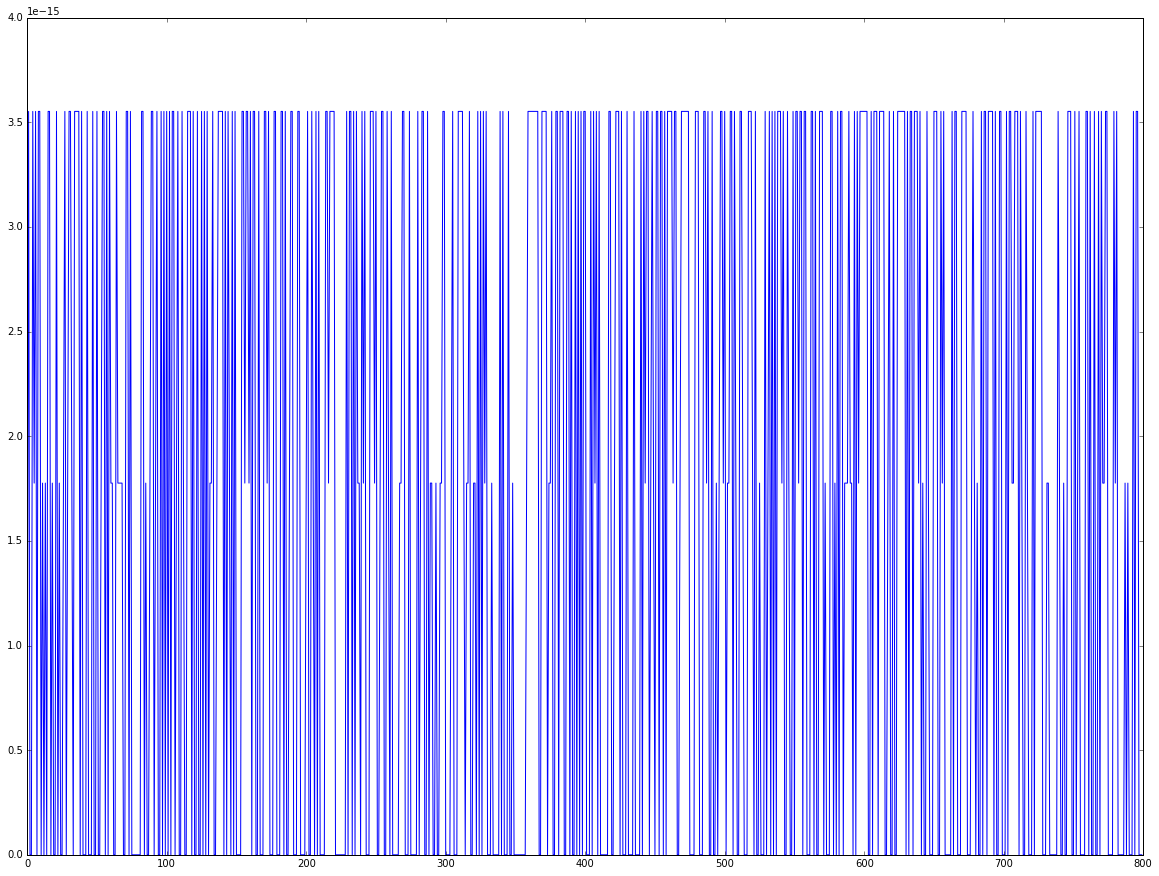

In [24]:
plt.plot(fslr.get_prediction(X_trainSLR).summary_frame(alpha=0.05)["obs_ci_lower"].values - iv_l_slr)

In [25]:
# reference: https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels
from statsmodels.stats.outliers_influence import summary_table
st, sum_data, ss2 = summary_table(fslr, alpha=0.05)

In [26]:
fittedvalues = sum_data[:,2]
print(np.max(np.abs(fslr.fittedvalues - fittedvalues)))

0.0


In [27]:
predict_mean_se  = sum_data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = sum_data[:,4:6].T
predict_ci_low, predict_ci_upp = sum_data[:,6:8].T

In [28]:
print (np.max(np.abs(iv_l_slr - predict_ci_low)))
print (np.max(np.abs(iv_u_slr - predict_ci_upp)))

7.15039733214
7.15039733214


In [29]:
X_trainSLR[100]

array([ 1.        , -0.31584484, -1.02477349, -1.66583379, -0.73251393,
       -0.93107004, -1.59795356,  1.03657356, -0.98131052, -0.95628483,
        1.5383201 ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ])

In [30]:
sum_data.shape

(800, 12)

In [31]:
X_trainSLR.shape

(800, 19)

In [32]:
data[FEATURES].std().values

array([  0.14170688,   0.14244921,   0.14557049,   0.07983643,
         0.15913476,   4.89489697,   0.04856153,  17.1897029 ,
         0.16279562,   0.90465317])

In [33]:
transformedDataLR

array([[ 0.18318786, -0.29167552,  0.48732075, ...,  0.        ,
         0.        ,  1.        ],
       [-1.09462985,  1.19580179, -0.16299888, ...,  0.        ,
         0.        ,  1.        ],
       [-0.83297322,  0.41620787,  1.09603147, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [-0.61253493, -0.9215623 , -1.69107131, ...,  0.        ,
         1.        ,  0.        ],
       [-0.91053825, -1.36166549,  1.26586235, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.18600494, -0.18045748,  0.23957798, ...,  0.        ,
         0.        ,  1.        ]])

In [34]:
mapperLRTemp = DataFrameMapper([
...     (['WtCohesion', 'WtAlignment','WtSeparation', 'WtSeek', 'wtExpBlend', 'Speed', 'Neighbourhood','WanderFreq', 'wanderRadius', 'kickTime'], preprocessing.StandardScaler()),
...     (['VelDirType'], preprocessing.OneHotEncoder()),    
...     (['dampExplore'], preprocessing.OneHotEncoder())], input_df = True, df_out = True)

In [35]:
transformedDataLRTemp = mapperLRTemp.fit_transform(data.copy())

In [36]:
transformedDataLRTemp.columns

Index(['WtCohesion_WtAlignment_WtSeparation_WtSeek_wtExpBlend_Speed_Neighbourhood_WanderFreq_wanderRadius_kickTime_0',
       'WtCohesion_WtAlignment_WtSeparation_WtSeek_wtExpBlend_Speed_Neighbourhood_WanderFreq_wanderRadius_kickTime_1',
       'WtCohesion_WtAlignment_WtSeparation_WtSeek_wtExpBlend_Speed_Neighbourhood_WanderFreq_wanderRadius_kickTime_2',
       'WtCohesion_WtAlignment_WtSeparation_WtSeek_wtExpBlend_Speed_Neighbourhood_WanderFreq_wanderRadius_kickTime_3',
       'WtCohesion_WtAlignment_WtSeparation_WtSeek_wtExpBlend_Speed_Neighbourhood_WanderFreq_wanderRadius_kickTime_4',
       'WtCohesion_WtAlignment_WtSeparation_WtSeek_wtExpBlend_Speed_Neighbourhood_WanderFreq_wanderRadius_kickTime_5',
       'WtCohesion_WtAlignment_WtSeparation_WtSeek_wtExpBlend_Speed_Neighbourhood_WanderFreq_wanderRadius_kickTime_6',
       'WtCohesion_WtAlignment_WtSeparation_WtSeek_wtExpBlend_Speed_Neighbourhood_WanderFreq_wanderRadius_kickTime_7',
       'WtCohesion_WtAlignment_WtSeparation_WtSe

In [37]:
X_trainLR, X_testLR, y_trainLR, y_testLR = model_selection.train_test_split(transformedDataLRTemp, scores_WTS, test_size=0.2, random_state=42)

In [38]:
X_trainLR.columns = ["WtCohesion", "WtAlignment", "WtSeparation", "WtSeek", "wtExpBlend", "Speed", "Neighbourhood", "WanderFreq", "wanderRadius", "kickTime", "forward", "backward", "right side","left side", "upwards", "downwards", "exploreOff", "exploreOn"]
X_testLR.columns = ["WtCohesion", "WtAlignment", "WtSeparation", "WtSeek", "wtExpBlend", "Speed", "Neighbourhood", "WanderFreq", "wanderRadius", "kickTime", "forward", "backward", "right side","left side", "upwards", "downwards", "exploreOff", "exploreOn"]

In [39]:
# X_trainLR.to_csv('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\LRBaselineArm\\XTrainLR.csv',index=False)

In [40]:
# X_testLR.to_csv('C:\\Users\\rutad\\Documents\\bitbucket\\pythonTF\\LRBaselineArm\\XTestLR.csv',index=False)

In [41]:
X_testLR.columns

Index(['WtCohesion', 'WtAlignment', 'WtSeparation', 'WtSeek', 'wtExpBlend',
       'Speed', 'Neighbourhood', 'WanderFreq', 'wanderRadius', 'kickTime',
       'forward', 'backward', 'right side', 'left side', 'upwards',
       'downwards', 'exploreOff', 'exploreOn'],
      dtype='object')

In [42]:
FEATURESALL

['WtCohesion',
 'WtAlignment',
 'WtSeparation',
 'WtSeek',
 'wtExpBlend',
 'Speed',
 'Neighbourhood',
 'WanderFreq',
 'wanderRadius',
 'kickTime',
 'VelDirType',
 'dampExplore']